In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pandas
import tensorflow as tf
import cv2
import seaborn
import pandas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve

# Chargement du dataset
- Chargement dataset
- Data augmentation et préprocessing lié au déséquilibrage
- Étudier SMOTE, pondération

In [32]:
PATH = "datasets/Qualite"

In [33]:
# étiquettes
class_names = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"]

In [64]:
# Enregistrer l'historique du model en CSV
def get_csv_logger(name: str) -> tf.keras.callbacks.CSVLogger:
    return tf.keras.callbacks.CSVLogger("saved_models/" + name + ".csv", separator=',', append=False)

csv_logger = tf.keras.callbacks.CSVLogger("saved_models/history.csv", separator=',', append=False, )

# usage :
# - save ==> model.fit(..., callbacks=[csv_logger])
# - load ==> log_data = pandas.read_csv('training.log', sep=',', engine='python')

In [28]:
batch_size = 32
img_height = 300
img_width = 300
IMG_SIZE = (img_width, img_height)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 18695 files belonging to 4 classes.
Using 14956 files for training.
Found 18695 files belonging to 4 classes.
Using 3739 files for validation.


In [29]:
# Crée jeu de tests
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [30]:
# affichage
imgs_take = train_ds.take(1)
imgs = {'img':[], 'label':[]}
for images, labels in imgs_take:
  for i in range(9):
      imgs['img'].append(images[i])
      imgs['label'].append(class_names[labels[i]])

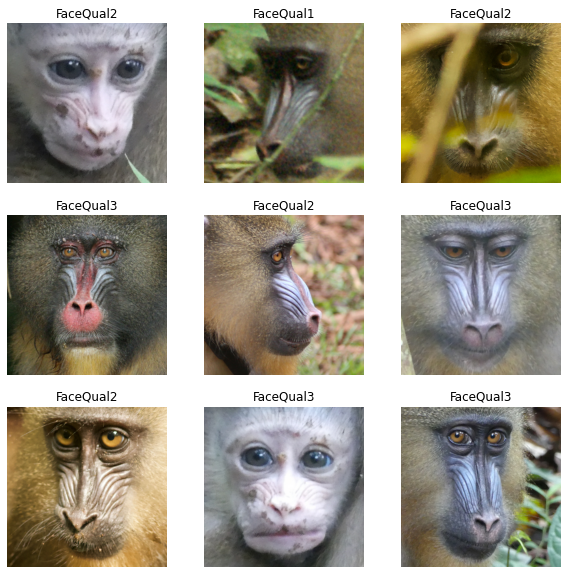

In [31]:
# affichage haute qualité
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs['img'][i].numpy().astype("uint8"))
    plt.title(imgs['label'][i])
    plt.axis("off")

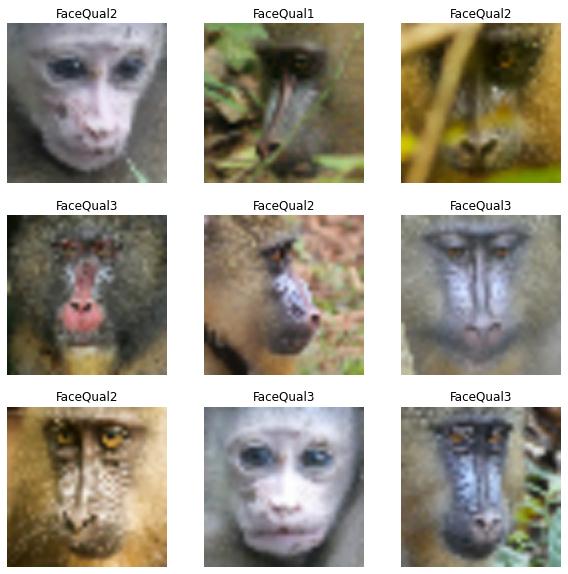

In [32]:
# generating the kernel
blur = 9
downscale = 40
kernel = np.ones((blur,blur),np.uint8)/pow(blur, 2)

# potentiel augmentation par dégradation des images de haute qualité
# a étudier : dégradation par encodage JPEG à fort taux de compression
# actuel : downscale => upscale => blur
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = tf.image.resize(imgs['img'][i], [downscale, downscale], method="nearest")
    img = tf.image.resize(img, [300, 300], method="nearest")
    output = cv2.filter2D(img.numpy(), -1, kernel)
    img = tf.convert_to_tensor(output)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(imgs['label'][i])
    plt.axis("off")

# Chargement du modèle et transfer learning
- Modèle existant : MobileNet V2, VGG16, EfficientNet...
- Poids existant : ImageNet
- Ajouter couches de convolutions pour extraire les features spécialisées

In [70]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # modele MobileNet V2 (rapide et correct)
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1) # [0, 255] => [-1, 1]

In [71]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [52]:
# Load model from file
model = tf.keras.models.load_model('saved_models/MNV2_GEL_IMBALANCED.h5')

OSError: SavedModel file does not exist at: saved_models/MNV2_GEL_IMBALANCED.h5\{saved_model.pbtxt|saved_model.pb}

In [72]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 300, 300, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 300, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_____________________________________________

In [73]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [74]:
# gel : a voir
base_model.trainable = False

In [75]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [76]:
prediction_layer = tf.keras.layers.Dense(4, activation="softmax") # prédiction sur 4 classes (4 neurones)

In [77]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False) # mobile net v2
x = global_average_layer(x) # moyenne des features
outputs = prediction_layer(x) # prediction
model = tf.keras.Model(inputs, outputs)

In [78]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  "accuracy",
              ],
              )

In [79]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

94/94 [==============================] - 7s 63ms/step - loss: 1.4607 - accuracy: 0.2298


In [80]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
468/468 [==============================] - 37s 76ms/step - loss: 0.8094 - accuracy: 0.6639 - val_loss: 0.6631 - val_accuracy: 0.7323
Epoch 2/10
468/468 [==============================] - 36s 76ms/step - loss: 0.6306 - accuracy: 0.7392 - val_loss: 0.5797 - val_accuracy: 0.7576
Epoch 3/10
468/468 [==============================] - 36s 76ms/step - loss: 0.5706 - accuracy: 0.7614 - val_loss: 0.5424 - val_accuracy: 0.7769
Epoch 4/10
468/468 [==============================] - 36s 76ms/step - loss: 0.5390 - accuracy: 0.7739 - val_loss: 0.5173 - val_accuracy: 0.7852
Epoch 5/10
468/468 [==============================] - 36s 76ms/step - loss: 0.5181 - accuracy: 0.7821 - val_loss: 0.4996 - val_accuracy: 0.7919
Epoch 6/10
468/468 [==============================] - 36s 76ms/step - loss: 0.5029 - accuracy: 0.7870 - val_loss: 0.4915 - val_accuracy: 0.7949
Epoch 7/10
468/468 [==============================] - 36s 76ms/step - loss: 0.4915 - accuracy: 0.7919 - val_loss: 0.4791 - val_accuracy:

In [91]:
pandas.DataFrame(history.history).to_csv("saved_model/history.csv")

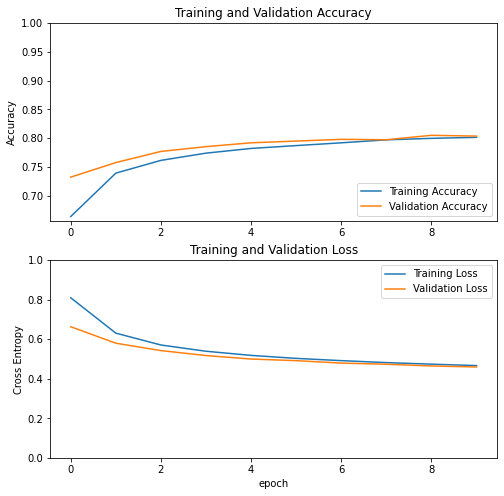

In [81]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

[0.00567448 0.07780132 0.84384495 0.07267921]
[8.1695209e-05 1.5266344e-04 3.5420317e-02 9.6434528e-01]
[0.00297988 0.09912583 0.7790353  0.11885903]
[0.00410459 0.03411704 0.76220065 0.19957772]
[0.00080379 0.00417175 0.32277256 0.6722519 ]
[0.00142842 0.00876561 0.88123155 0.10857441]
[0.00088827 0.00470724 0.16377802 0.8306265 ]
[0.0333112  0.551381   0.41291866 0.00238922]
[0.0036422  0.01605835 0.7313905  0.24890903]


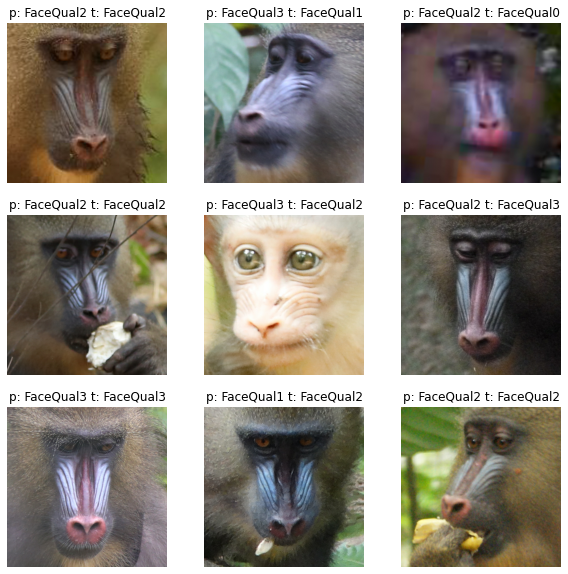

In [83]:
predictions = model.predict(test_dataset)
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    print(predictions[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("p: " + class_names[np.argmax(predictions[i])] + " t: " + class_names[labels[i]])
    plt.axis("off")

In [84]:
#model.save('saved_model/mobilenetv2_qualite_gel')
model.save("saved_model/mobilenetv2_qualite_gel.h5")

# On fine-tune le modèle une fois qu'il a "appris au maximum"
- defreezing de layers supérieurs
- il faudra faire varier aussi sans doute le learning rate

In [85]:
base_model.trainable = True

In [86]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [87]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), # learning rate + faible que dans la 1re partie
              metrics=['accuracy'])

In [88]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 10/20
468/468 [==============================] - 55s 103ms/step - loss: 0.4424 - accuracy: 0.8119 - val_loss: 0.4027 - val_accuracy: 0.8365
Epoch 11/20
468/468 [==============================] - 47s 100ms/step - loss: 0.3744 - accuracy: 0.8451 - val_loss: 0.3834 - val_accuracy: 0.8395
Epoch 12/20
468/468 [==============================] - 47s 100ms/step - loss: 0.3330 - accuracy: 0.8665 - val_loss: 0.3542 - val_accuracy: 0.8545
Epoch 13/20
468/468 [==============================] - 46s 99ms/step - loss: 0.2931 - accuracy: 0.8816 - val_loss: 0.3700 - val_accuracy: 0.8455
Epoch 14/20
468/468 [==============================] - 46s 99ms/step - loss: 0.2674 - accuracy: 0.8964 - val_loss: 0.3261 - val_accuracy: 0.8631
Epoch 15/20
468/468 [==============================] - 46s 99ms/step - loss: 0.2379 - accuracy: 0.9120 - val_loss: 0.3485 - val_accuracy: 0.8571
Epoch 16/20
468/468 [==============================] - 47s 99ms/step - loss: 0.2140 - accuracy: 0.9215 - val_loss: 0.3211 - val

In [89]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [90]:
pandas.DataFrame(history_fine.history).to_csv("saved_model/history2.csv")

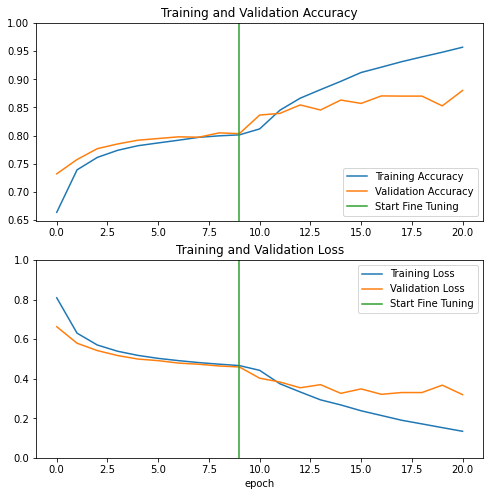

In [92]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Analyse des résultats
- précision prédiction
- mesure du déséquilibre

[2.0453128e-06 1.9415912e-04 9.9924928e-01 5.5454875e-04]
[3.6150148e-08 2.1342141e-06 9.1414112e-01 8.5856654e-02]
[1.8480530e-06 6.5419867e-05 9.4695526e-01 5.2977405e-02]
[3.4752393e-05 3.7266596e-04 9.7161013e-01 2.7982363e-02]
[3.1406655e-09 1.0834444e-06 9.9960870e-01 3.9022326e-04]
[1.5464387e-07 5.5104574e-05 9.9986970e-01 7.4919350e-05]
[1.6795101e-07 1.9741796e-05 9.9951243e-01 4.6762149e-04]
[9.7988435e-09 1.7179426e-06 2.5777124e-02 9.7422111e-01]
[7.5391104e-10 7.4791217e-08 9.6214972e-03 9.9037838e-01]
[2.5582232e-05 7.1290205e-04 9.9897408e-01 2.8743641e-04]
[4.0797516e-09 2.2150102e-06 1.9371295e-01 8.0628490e-01]
[2.4515123e-04 9.0964986e-03 9.9061221e-01 4.6207264e-05]
[1.4896902e-05 1.0277469e-03 9.5470780e-01 4.4249613e-02]
[1.5868420e-07 2.4433076e-04 9.9408507e-01 5.6704115e-03]
[2.1830026e-06 9.4904062e-05 9.3576914e-01 6.4133786e-02]
[2.0979919e-06 9.2342430e-05 3.1449893e-01 6.8540663e-01]
[1.0819882e-02 8.6604133e-02 9.0252793e-01 4.8123893e-05]
[1.0148030e-06

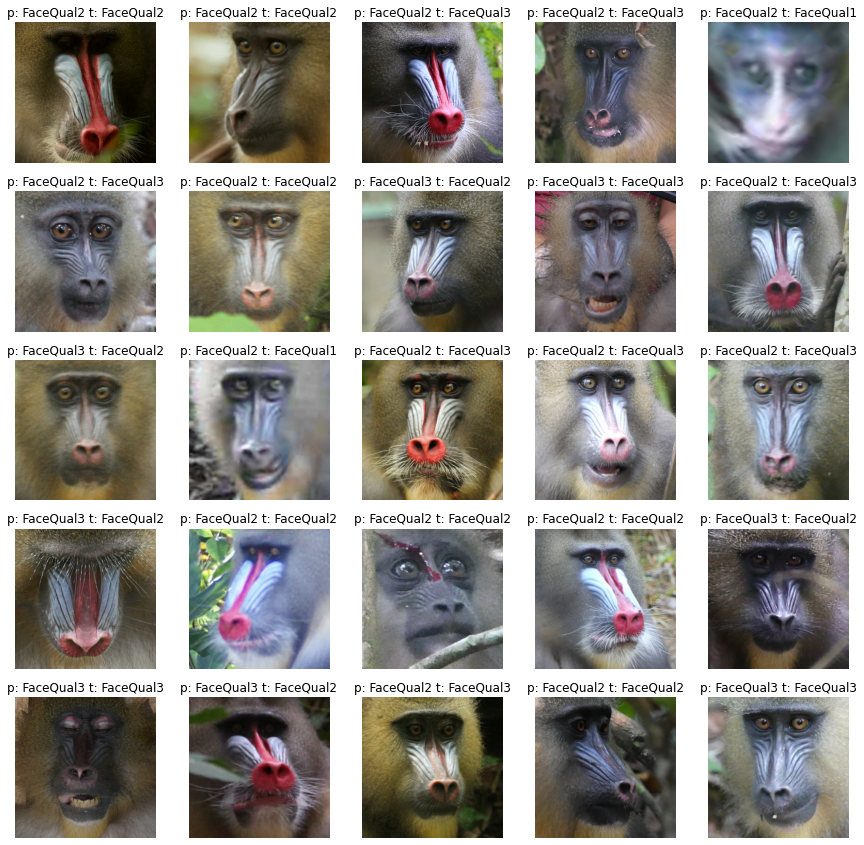

In [93]:
predictions = model.predict(test_dataset)
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
  for i in range(25):
    print(predictions[i])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("p: " + class_names[np.argmax(predictions[i])] + " t: " + class_names[labels[i]])
    plt.axis("off")

In [144]:
# Classification report

y_valid = np.concatenate([y for x,y in validation_ds], axis=0)
y_pred = np.argmax(model.predict(validation_ds), axis=1)

print(classification_report(y_valid, y_pred, target_names=class_names))


              precision    recall  f1-score   support

   FaceQual0       0.00      0.00      0.00        35
   FaceQual1       0.05      0.03      0.04       191
   FaceQual2       0.60      0.64      0.62      1817
   FaceQual3       0.33      0.32      0.32       960

    accuracy                           0.49      3003
   macro avg       0.24      0.25      0.25      3003
weighted avg       0.47      0.49      0.48      3003



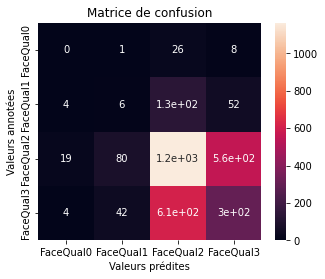

In [145]:
# Matrice de confusion

cm = confusion_matrix(y_valid, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm = pandas.DataFrame(cm,
                     index = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"],
                     columns = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
seaborn.heatmap(cm, annot=True)
plt.title('Matrice de confusion')
plt.ylabel('Valeurs annotées')
plt.xlabel('Valeurs prédites')
plt.show()

In [147]:
# Graphe ROC

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Validation Baseline", validation_ds, y_pred, color=colors[0])
#plot_roc("Test Baseline", test_dataset[1], test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

ValueError: Expected array-like (array or non-string sequence), got <SkipDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>